# Model 1: Multivariate-3-RNN

## RNN

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

2025-05-29 05:50:47.080227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748497847.107350   12257 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748497847.114282   12257 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras import optimizers

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [5]:
plt.style.use('ggplot')

### Hàm callback

In [6]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-hpg-rnn.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [8]:
print(df.head)

<bound method NDFrame.head of              open   high    low  close    volume
time                                            
2007-11-16   2.29   2.29   2.29   2.29    248510
2007-11-19   2.17   2.17   2.17   2.17    120480
2007-11-20   2.08   2.08   2.08   2.08     58710
2007-11-21   1.99   2.16   1.99   2.16    728080
2007-11-22   2.16   2.16   2.08   2.16    266040
...           ...    ...    ...    ...       ...
2025-03-14  27.70  27.85  27.55  27.55  18279900
2025-03-17  27.90  28.15  27.75  27.85  19719700
2025-03-18  27.90  28.05  27.60  27.60  18741700
2025-03-19  27.60  27.60  27.10  27.25  37925600
2025-03-20  27.30  27.45  27.05  27.15  25022500

[4322 rows x 5 columns]>


In [9]:
print(df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


### Tiền xử lí dữ liệu

In [10]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [11]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

In [12]:
#  Tính toán các thống kê mô tả như trung bình (mean), độ lệch chuẩn (std), min, max, phần trăm phân vị (25%, 50%, 75%).
print(df.describe().volume) # Giúp kiểm tra phân bố của Volume, phát hiện các giá trị bất thường (outliers).

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

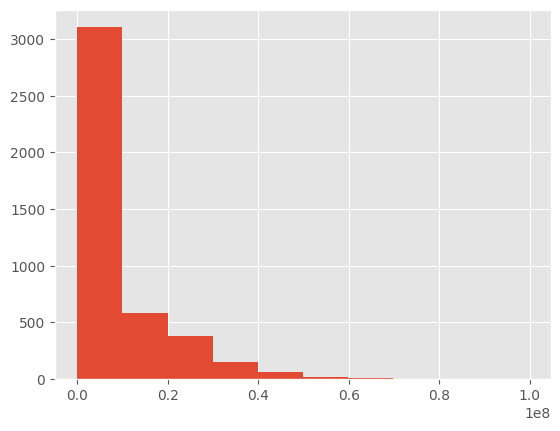

In [13]:
# Vẽ biểu đồ tần suất của Volume
df['volume'].hist(bins=10)

**Phân tích phân bố dữ liệu Volume bằng Histogram**  

🔹 `.hist(bins=10)`  
- Vẽ **biểu đồ histogram** của cột `Volume` với **10 bins (nhóm dữ liệu)**.  
- Giúp trực quan hóa **phân bố dữ liệu**, phát hiện sự **lệch** (skewness) và **giá trị ngoại lai** (outliers).  

**Ý nghĩa của biểu đồ histogram**  

- **Nếu phân bố lệch phải (right-skewed)** → Dữ liệu có nhiều giá trị nhỏ, một số giá trị rất lớn.  
- **Nếu phân bố lệch trái (left-skewed)** → Dữ liệu có nhiều giá trị lớn, một số giá trị rất nhỏ.  
- **Nếu có outliers (điểm nằm xa tập trung chính)** → Có thể cần xử lý như **loại bỏ** hoặc **chuẩn hóa dữ liệu**.  

**Cách xử lý dữ liệu lệch/skewed**  

✅ **Log Transformation** → Dùng `np.log1p(Volume)` để giảm độ lệch.  
✅ **Scaling** → Dùng `MinMaxScaler()` hoặc `StandardScaler()` để chuẩn hóa.  
✅ **Xử lý outliers** → Loại bỏ hoặc thay thế bằng **giá trị trung bình/median**.  


In [14]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [15]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2007-11-16  2.29  2.29  2.29   2.29  248510    NaN    NaN    NaN  2.290000   
2007-11-19  2.17  2.17  2.17   2.17  120480    NaN    NaN    NaN  2.271538   
2007-11-20  2.08  2.08  2.08   2.08   58710    NaN    NaN    NaN  2.242071   
2007-11-21  1.99  2.16  1.99   2.16  728080    NaN    NaN    NaN  2.229445   
2007-11-22  2.16  2.16  2.08   2.16  266040    NaN    NaN    NaN  2.218761   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2007-11-16  2.290000  0.000000  NaN  NaN NaN NaN  
2007-11-19  2.281111 -0.009573  NaN  NaN NaN NaN  
2007-11-20  2.266214 -0.024143  NaN  NaN NaN NaN  
2007-11-21  2.258346 -0.028902  NaN  NaN NaN NaN  
2007-11-22  2.251061 -0.032300  NaN  NaN NaN NaN  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


(4320, 15)

## Train model / Hàm **fit_model_2()**

In [16]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate= lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    for layer in model.layers:
        if isinstance(layer, SimpleRNN):
            layer.reset_states() #Đảm bảo mỗi lần huấn luyện không bị ảnh hưởng bởi trạng thái cũ của LSTM.
    return model, history.history['loss'], history.history['val_loss']

###  Bước 1: Đặt Seed để đảm bảo tính tái lập

Giúp đảm bảo mỗi lần chạy chương trình, các giá trị ngẫu nhiên được tạo ra giống nhau, tránh kết quả huấn luyện thay đổi giữa các lần chạy.

In [17]:
"""
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)
"""

'\nnp.random.seed(1)\ntf.random.set_seed(2)\nrn.seed(3)\n'

### Bước 2: Chuẩn bị dữ liệu huấn luyện (train) và kiểm định (val)

In [18]:
"""
X_train = []
Y_train = []
X_val = []
Y_val = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train, Y_train = np.array(X_train, Y_train)

for i in range(timesteps, val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val, Y_val = np.array(X_val, Y_val)  
"""

'\nX_train = []\nY_train = []\nX_val = []\nY_val = []\n\nfor i in range(timesteps, train.shape[0]):\n    X_train.append(train[i-timesteps:i])\n    Y_train.append(train[i][0])\nX_train, Y_train = np.array(X_train, Y_train)\n\nfor i in range(timesteps, val.shape[0]):\n    X_val.append(val[i-timesteps:i])\n    Y_val.append(val[i][0])\nX_val, Y_val = np.array(X_val, Y_val)  \n'

### Bước 3: Xây dựng mô hình RNN

In [19]:
"""
# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
for i in range(len(hl)-1):
    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))
model.add(SimpleRNN(hl[-1], activation='relu'))
model.add(Dense(1))
"""

"\n# Xây dựng mô hình RNN\nmodel = Sequential()\nmodel.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))\nfor i in range(len(hl)-1):\n    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))\nmodel.add(SimpleRNN(hl[-1], activation='relu'))\nmodel.add(Dense(1))\n"

Thêm một lớp **SimpleRNN đầu tiên**:  
-   `X_train.shape[2]`: Số đặc trưng (features).
-   `input_shape = (X_train.shape[1], X_train.shape[2])`: Định dạng đầu vào (timesteps, số đặc trưng).
-   `activation = 'relu'`: Hàm kích hoạt giúp mô hình học phi tuyến tính.
-   `return_sequences = True`: Giữ lại toàn bộ chuỗi đầu ra để sử dụng trong các lớp tiếp theo.

### Bước 4: Biên dịch mô hình

In [20]:
"""
# Biên dịch
model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')
"""

"\n# Biên dịch\nmodel.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')\n"

### Bước 5: Huấn luyện mô hình

In [21]:
"""
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
"""

'\nhistory = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)\n'

**Cấu hình huấn luyện mô hình**

🔹 Tham số trong quá trình huấn luyện  

✅ `epochs = epochs` → Số vòng huấn luyện  
✅ `batch_size = batch` → Kích thước batch  
✅ `validation_data = (X_val, Y_val)` → Dữ liệu kiểm định để theo dõi hiệu suất sau mỗi epoch  
✅ `verbose = 0` → Không hiển thị log huấn luyện (có thể đặt `verbose = 1` để xem tiến trình)  
✅ `shuffle = False` → Không xáo trộn dữ liệu (do chuỗi thời gian có tính thứ tự)  
✅ `callbacks = callbacks_list` → Danh sách callback hỗ trợ huấn luyện  

### Bước 6: Đảm bảo trạng thái không bị ảnh hưởng khi huấn luyện nhiều lần

In [22]:
"""
for layer in model.layers:
    if isinstance(layer, SimpleRNN):
        layer.reset_states()
"""

'\nfor layer in model.layers:\n    if isinstance(layer, SimpleRNN):\n        layer.reset_states()\n'

### Bước 7: Trả về kết quả

In [23]:
"""
return model, history.history['train_loss'], history.history['val_loss']
"""

"\nreturn model, history.history['train_loss'], history.history['val_loss']\n"

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [24]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [25]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model_2(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

## Hàm **Evaluate_model_2()**

In [26]:
"""
# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100"
    """

'\n# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true))*100"\n    '

In [27]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart (vẽ biểu đồ)

In [28]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [29]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [30]:
# Extracting the series
series = df[['close', 'high', 'low', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4267, 12)
            close   high    low   CMA10   SMA10   SMA50      EMA12        RSI  \
time                                                                            
2025-03-10  27.95  28.20  27.95  27.860  27.910  26.726  27.664525  66.666667   
2025-03-11  28.15  28.15  27.60  27.840  27.975  26.749  27.739213  68.965517   
2025-03-12  27.80  28.20  27.80  27.815  27.980  26.771  27.748565  63.440860   
2025-03-13  27.70  28.05  27.70  27.785  27.905  26.782  27.741094  63.440860   
2025-03-14  27.55  27.85  27.55  27.705  27.860  26.793  27.711695  47.887324   

                  CCI         %K         %D      MACD  
time                                                   
2025-03-10  72.152412  75.609756  78.723924  0.419877  
2025-03-11  61.493516  85.365854  80.790320  0.427503  
2025-03-12  54.366686  68.292683  76.422764  0.400685  
2025-03-13  39.488661  40.000000  64.552846  0.367130  
2025-03-14  16.260163  28.000000  45.430894  0.324692  


In [31]:
series.describe()

,close,high,low,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4267.000000,4267.000000,4267.000000,4267.000000,4267.00000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000
mean,10.025397,10.160349,9.903063,10.022310,9.99800,9.880565,9.992086,52.254060,12.008518,53.007353,53.000609,0.041366
std,10.126221,10.264080,10.012208,10.118056,10.10649,10.019039,10.097556,17.992688,112.438235,30.851704,29.031483,0.373255
min,0.680000,0.690000,0.680000,0.710000,0.71000,0.793800,0.726093,0.000000,-486.486486,0.000000,0.000000,-1.739242
25%,1.780000,1.800000,1.760000,1.778000,1.77800,1.760400,1.776499,38.724730,-76.041990,25.730277,26.681097,-0.045488
50%,5.680000,5.780000,5.610000,5.725000,5.70500,5.174200,5.719069,52.577320,21.806854,55.445545,55.238095,0.020672
75%,15.415000,15.655000,15.275000,15.376000,15.21950,15.065600,15.178271,66.146301,101.156626,80.702355,79.987975,0.119916
max,39.900000,40.180000,39.560000,39.285000,39.28500,37.489200,39.090578,100.000000,364.285714,100.000000,100.000000,2.247325


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [32]:
series.shape

(4267, 12)

In [33]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2987, 12) (640, 12) (640, 12)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [34]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2987, 12) (640, 12) (640, 12)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [35]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)


Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


I0000 00:00:1748497852.244358   12257 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748497852.244998   12257 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1748497857.291931   12309 service.cc:148] XLA service 0x793b500b9cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748497857.291962   12309 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Ca


Epoch 1: val_loss improved from inf to 1.03951, saving model to 10Var-hpg-rnn.h5

Epoch 2: val_loss improved from 1.03951 to 0.50758, saving model to 10Var-hpg-rnn.h5

Epoch 3: val_loss improved from 0.50758 to 0.24866, saving model to 10Var-hpg-rnn.h5

Epoch 4: val_loss improved from 0.24866 to 0.12737, saving model to 10Var-hpg-rnn.h5

Epoch 5: val_loss improved from 0.12737 to 0.07982, saving model to 10Var-hpg-rnn.h5

Epoch 6: val_loss improved from 0.07982 to 0.05849, saving model to 10Var-hpg-rnn.h5

Epoch 7: val_loss improved from 0.05849 to 0.04698, saving model to 10Var-hpg-rnn.h5

Epoch 8: val_loss improved from 0.04698 to 0.04039, saving model to 10Var-hpg-rnn.h5

Epoch 9: val_loss improved from 0.04039 to 0.03633, saving model to 10Var-hpg-rnn.h5

Epoch 10: val_loss improved from 0.03633 to 0.03264, saving model to 10Var-hpg-rnn.h5

Epoch 11: val_loss improved from 0.03264 to 0.02947, saving model to 10Var-hpg-rnn.h5

Epoch 12: val_loss improved from 0.02947 to 0.02673, sa

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [36]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00355

Epoch 2: val_loss did not improve from 0.00355

Epoch 3: val_loss did not improve from 0.00355

Epoch 4: val_loss did not improve from 0.00355

Epoch 5: val_loss did not improve from 0.00355

Epoch 6: val_loss did not improve from 0.00355

Epoch 7: val_loss did not improve from 0.00355

Epoch 8: val_loss did not improve from 0.00355

Epoch 9: val_loss did not improve from 0.00355

Epoch 10: val_loss did not improve from 0.00355

Epoch 11: val_loss did not improve from 0.00355

Epoch 12: val_loss did not improve from 0.00355

Epoch 13: val_loss did not improve from 0.00355

Epoch 14: val_loss did not improve from 0.00355

Epoch 15: val_loss did not improve from 0.00355

Epoch 16: val_loss did not improve from 0.00355

Epoch 17: val_loss did not improve from 0.00355

Epoch 18: val_loss did not improve from 0.00355

Epoch 19: val_loss did not improve from 0.00355

Epoch 20: val_loss did not improve from 0.00355

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

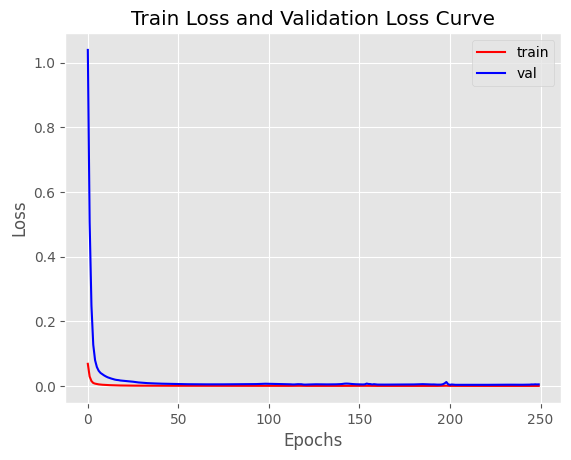

In [37]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [38]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [39]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0032228066365874546
RMSE = 0.05676976868534391
MAPE = 0.03019993698101792
R-Squared Score = 0.9579559753444818


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

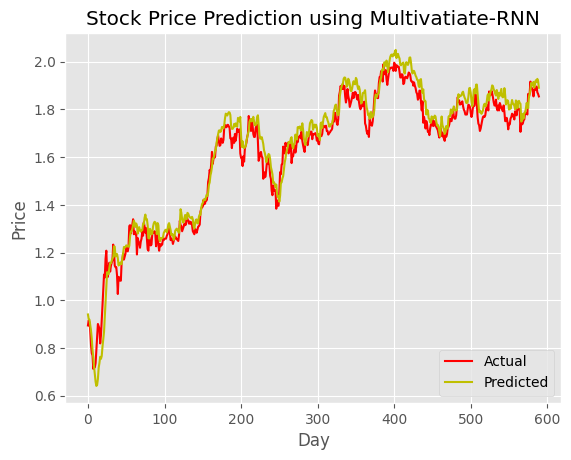

In [40]:
plot_data_2(true, predicted)

In [41]:
# Save a model
model.save('10VAR-hpg-rnn.keras')

In [42]:
del model

# Model 2: Multivariate-3-GRU

## GRU

### Import các thư viện cần thiết

In [43]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [44]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras import optimizers

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [47]:
plt.style.use('ggplot')

### Hàm callback

In [51]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-hpg-gru.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [54]:
df.head()

,open,high,low,close,volume
time,,,,,
2007-11-16,2.29,2.29,2.29,2.29,248510
2007-11-19,2.17,2.17,2.17,2.17,120480
2007-11-20,2.08,2.08,2.08,2.08,58710
2007-11-21,1.99,2.16,1.99,2.16,728080
2007-11-22,2.16,2.16,2.08,2.16,266040


In [55]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [56]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [57]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

In [58]:
print(df.describe().volume) 

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

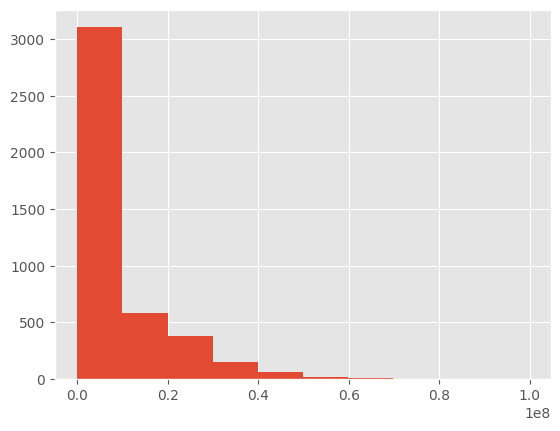

In [59]:
df['volume'].hist(bins= 10)

In [60]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [61]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2007-11-16  2.29  2.29  2.29   2.29  248510    NaN    NaN    NaN  2.290000   
2007-11-19  2.17  2.17  2.17   2.17  120480    NaN    NaN    NaN  2.271538   
2007-11-20  2.08  2.08  2.08   2.08   58710    NaN    NaN    NaN  2.242071   
2007-11-21  1.99  2.16  1.99   2.16  728080    NaN    NaN    NaN  2.229445   
2007-11-22  2.16  2.16  2.08   2.16  266040    NaN    NaN    NaN  2.218761   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2007-11-16  2.290000  0.000000  NaN  NaN NaN NaN  
2007-11-19  2.281111 -0.009573  NaN  NaN NaN NaN  
2007-11-20  2.266214 -0.024143  NaN  NaN NaN NaN  
2007-11-21  2.258346 -0.028902  NaN  NaN NaN NaN  
2007-11-22  2.251061 -0.032300  NaN  NaN NaN NaN  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


(4320, 15)

## Train model / Hàm **fit_model_3()**

In [62]:
def fit_model_3(train, val, timesteps, hl, lr, batch, epochs):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)
    """
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Thêm các lớp vào mô hình
    model = Sequential()
    model.add(GRU(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i], activation='relu', return_sequences= True))
    model.add(GRU(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện dữ liệu
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)
    
    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, GRU):
            layer.reset_states()
    
    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_3()**

In [64]:
def evaluate_model_3(model, test, timesteps):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    """
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)

    # Các chỉ số đánh giá
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat


## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [66]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-4, 1e-3],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [67]:
# Hàm grid search
def grid_search_rnn(train, val, test, param_grid):
    results = []
    best_score = float('inf')
    best_params = None

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*(param_grid.values())))
    param_names = param_grid.keys()

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f'Training with params: {params}')

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

        # Trả về kết quả
        results_df = pd.DataFrame(results)
        return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [68]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [69]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [70]:
# Extracting the series
series = df[['close', 'high', 'low', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4267, 12)
            close   high    low   CMA10   SMA10   SMA50      EMA12        RSI  \
time                                                                            
2025-03-10  27.95  28.20  27.95  27.860  27.910  26.726  27.664525  66.666667   
2025-03-11  28.15  28.15  27.60  27.840  27.975  26.749  27.739213  68.965517   
2025-03-12  27.80  28.20  27.80  27.815  27.980  26.771  27.748565  63.440860   
2025-03-13  27.70  28.05  27.70  27.785  27.905  26.782  27.741094  63.440860   
2025-03-14  27.55  27.85  27.55  27.705  27.860  26.793  27.711695  47.887324   

                  CCI         %K         %D      MACD  
time                                                   
2025-03-10  72.152412  75.609756  78.723924  0.419877  
2025-03-11  61.493516  85.365854  80.790320  0.427503  
2025-03-12  54.366686  68.292683  76.422764  0.400685  
2025-03-13  39.488661  40.000000  64.552846  0.367130  
2025-03-14  16.260163  28.000000  45.430894  0.324692  


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [71]:
series.shape

(4267, 12)

In [72]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2987, 12) (640, 12) (640, 12)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [73]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2987, 12) (640, 12) (640, 12)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [74]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 3.39805, saving model to 10Var-hpg-gru.h5

Epoch 2: val_loss improved from 3.39805 to 2.78381, saving model to 10Var-hpg-gru.h5

Epoch 3: val_loss improved from 2.78381 to 2.19997, saving model to 10Var-hpg-gru.h5

Epoch 4: val_loss improved from 2.19997 to 1.64432, saving model to 10Var-hpg-gru.h5

Epoch 5: val_loss improved from 1.64432 to 1.07004, saving model to 10Var-hpg-gru.h5

Epoch 6: val_loss improved from 1.07004 to 0.58237, saving model to 10Var-hpg-gru.h5

Epoch 7: val_loss improved from 0.58237 to 0.28054, saving model to 10Var-hpg-gru.h5

Epoch 8: val_loss improved from 0.28054 to 0.15742, saving model to 10Var-hpg-gru.h5

Epoch 9: val_loss improved from 0.15742 to 0.11269, saving model to 10Var-hpg-gru.h5

Epoch 10: val_loss improved from 0.11269 to 0.09387, saving model to 10Var-hpg-gru.h5

Epoch 11: val_loss improved from 0.09387 to 0.08231, saving model to 10Var-hpg-gru.h5

Epoch 12: val_loss improved from 0.08231 to 0.07416, sa

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [75]:
timesteps = 30
hl = [40, 35]
lr = 1e-4
batch_size = 32
num_epochs = 200

model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00665

Epoch 2: val_loss did not improve from 0.00665

Epoch 3: val_loss did not improve from 0.00665

Epoch 4: val_loss did not improve from 0.00665

Epoch 5: val_loss did not improve from 0.00665

Epoch 6: val_loss did not improve from 0.00665

Epoch 7: val_loss did not improve from 0.00665

Epoch 8: val_loss did not improve from 0.00665

Epoch 9: val_loss did not improve from 0.00665

Epoch 10: val_loss did not improve from 0.00665

Epoch 11: val_loss did not improve from 0.00665

Epoch 12: val_loss did not improve from 0.00665

Epoch 13: val_loss did not improve from 0.00665

Epoch 14: val_loss did not improve from 0.00665

Epoch 15: val_loss did not improve from 0.00665

Epoch 16: val_loss did not improve from 0.00665

Epoch 17: val_loss did not improve from 0.00665

Epoch 18: val_loss did not improve from 0.00665

Epoch 19: val_loss did not improve from 0.00665

Epoch 20: val_loss did not improve from 0.00665

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

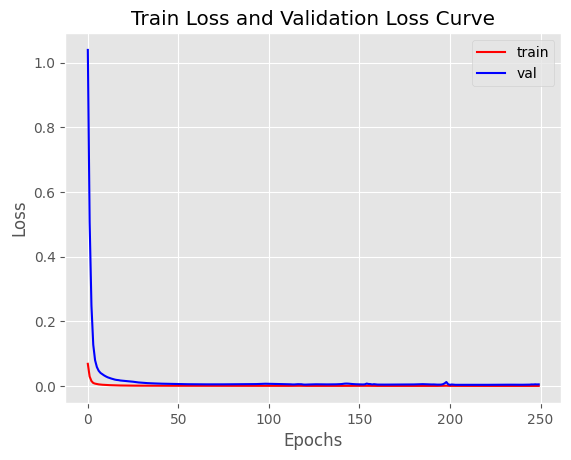

In [76]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [77]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step 


In [78]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.011491188687233096
RMSE = 0.10719696211755768
MAPE = 0.05958831968890106
R-Squared Score = 0.8617326787452297


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

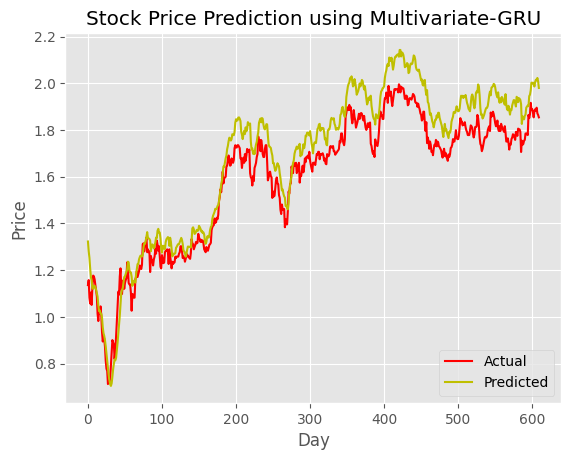

In [79]:
plot_data_3(true, predicted)

In [ ]:
# Save a model
model.save('10VAR-hpg-gru.keras')

In [ ]:
del model

# Model 3: Multivariate-3-LSTM

## LSTM

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

2025-06-02 14:45:45.424172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748875545.658327      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748875545.729589      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

In [7]:
plt.style.use('ggplot')

### Hàm callback

In [8]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var_hpg_lstm.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [10]:
df.head()

,open,high,low,close,volume
time,,,,,
2007-11-16,2.29,2.29,2.29,2.29,248510
2007-11-19,2.17,2.17,2.17,2.17,120480
2007-11-20,2.08,2.08,2.08,2.08,58710
2007-11-21,1.99,2.16,1.99,2.16,728080
2007-11-22,2.16,2.16,2.08,2.16,266040


In [11]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [12]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [13]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

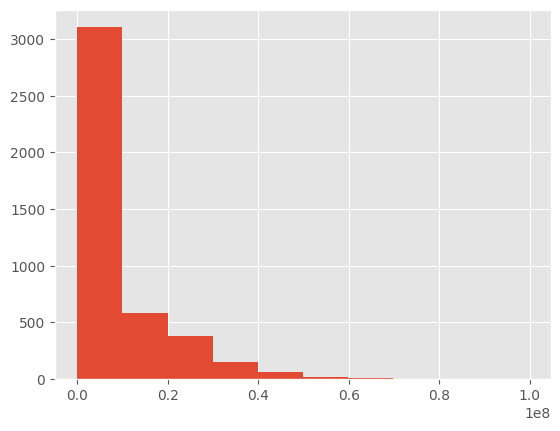

In [14]:
print(df.describe().volume) 
df['volume'].hist(bins= 10)

In [15]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [16]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2007-11-16  2.29  2.29  2.29   2.29  248510    NaN    NaN    NaN  2.290000   
2007-11-19  2.17  2.17  2.17   2.17  120480    NaN    NaN    NaN  2.271538   
2007-11-20  2.08  2.08  2.08   2.08   58710    NaN    NaN    NaN  2.242071   
2007-11-21  1.99  2.16  1.99   2.16  728080    NaN    NaN    NaN  2.229445   
2007-11-22  2.16  2.16  2.08   2.16  266040    NaN    NaN    NaN  2.218761   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2007-11-16  2.290000  0.000000  NaN  NaN NaN NaN  
2007-11-19  2.281111 -0.009573  NaN  NaN NaN NaN  
2007-11-20  2.266214 -0.024143  NaN  NaN NaN NaN  
2007-11-21  2.258346 -0.028902  NaN  NaN NaN NaN  
2007-11-22  2.251061 -0.032300  NaN  NaN NaN NaN  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


(4320, 15)

## Train model / Hàm **fit_model_4()**

In [17]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation='relu', return_sequences= True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, batch_size= batch, epochs= epochs, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)

    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_state()

    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_4()**

In [18]:
def evaluate_model_4(model, test, timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Các chỉ số
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [19]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [20]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [21]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [22]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [23]:
# Extracting the series
series = df[['close', 'high', 'low', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()

(4267, 12)


,close,high,low,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4267.000000,4267.000000,4267.000000,4267.000000,4267.00000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000
mean,10.025397,10.160349,9.903063,10.022310,9.99800,9.880565,9.992086,52.254060,12.008518,53.007353,53.000609,0.041366
std,10.126221,10.264080,10.012208,10.118056,10.10649,10.019039,10.097556,17.992688,112.438235,30.851704,29.031483,0.373255
min,0.680000,0.690000,0.680000,0.710000,0.71000,0.793800,0.726093,0.000000,-486.486486,0.000000,0.000000,-1.739242
25%,1.780000,1.800000,1.760000,1.778000,1.77800,1.760400,1.776499,38.724730,-76.041990,25.730277,26.681097,-0.045488
50%,5.680000,5.780000,5.610000,5.725000,5.70500,5.174200,5.719069,52.577320,21.806854,55.445545,55.238095,0.020672
75%,15.415000,15.655000,15.275000,15.376000,15.21950,15.065600,15.178271,66.146301,101.156626,80.702355,79.987975,0.119916
max,39.900000,40.180000,39.560000,39.285000,39.28500,37.489200,39.090578,100.000000,364.285714,100.000000,100.000000,2.247325


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [24]:
series.shape

(4267, 12)

In [25]:

n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)


(2987, 12) (640, 12) (640, 12)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [26]:
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2987, 12) (640, 12) (640, 12)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [101]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.15308, saving model to 10Var_hpg_lstm.h5

Epoch 2: val_loss did not improve from 0.15308

Epoch 3: val_loss did not improve from 0.15308

Epoch 4: val_loss improved from 0.15308 to 0.10063, saving model to 10Var_hpg_lstm.h5

Epoch 5: val_loss did not improve from 0.10063

Epoch 6: val_loss did not improve from 0.10063

Epoch 7: val_loss did not improve from 0.10063

Epoch 8: val_loss did not improve from 0.10063

Epoch 9: val_loss did not improve from 0.10063

Epoch 10: val_loss did not improve from 0.10063

Epoch 11: val_loss did not improve from 0.10063

Epoch 12: val_loss did not improve from 0.10063

Epoch 13: val_loss did not improve from 0.10063

Epoch 14: val_loss did not improve from 0.10063

Epoch 15: val_loss did not improve from 0.10063

Epoch 16: val_loss did not improve from 0.10063

Epoch 17: val_loss did not improve from 0.10063

Epoch 18: val_loss did not improve from 0.10063

Epoch 19: val_loss did not improve from 0.10063

Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.10063

Epoch 2: val_loss did not improve from 0.10063

Epoch 3: val_loss improved from 0.10063 to 0.07421, saving model to 10Var_hpg_lstm.h5

Epoch 4: val_loss did not improve from 0.07421

Epoch 5: val_loss did not improve from 0.07421

Epoch 6: val_loss did not improve from 0.07421

Epoch 7: val_loss did not improve from 0.07421

Epoch 8: val_loss did not improve from 0.07421

Epoch 9: val_loss did not improve from 0.07421

Epoch 10: val_loss did not improve from 0.07421

Epoch 11: val_loss did not improve from 0.07421

Epoch 12: val_loss did not improve from 0.07421

Epoch 13: val_loss did not improve from 0.07421

Epoch 14: val_loss did not improve from 0.07421

Epoch 15: val_loss did not improve from 0.07421

Epoch 16: val_loss did not improve from 0.07421

Epoch 17: val_loss did not improve from 0.07421

Epoch 18: val_loss did not improve from 0.07421

Epoch 19: val_loss did not improve from 0.07421

Epoch 20: val_loss did not improve fro

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not improve from 0.00808

Epoch 22: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00808

Epoch 2: val_loss did not improve from 0.00808

Epoch 3: val_loss did not improve from 0.00808

Epoch 4: val_loss did not improve from 0.00808

Epoch 5: val_loss did not improve from 0.00808

Epoch 6: val_loss did not improve from 0.00808

Epoch 7: val_loss did not improve from 0.00808

Epoch 8: val_loss did not improve from 0.00808

Epoch 9: val_loss did not improve from 0.00808

Epoch 10: val_loss did not improve from 0.00808

Epoch 11: val_loss did not improve from 0.00808

Epoch 12: val_loss did not improve from 0.00808

Epoch 13: val_loss did not improve from 0.00808

Epoch 14: val_loss did not improve from 0.00808

Epoch 15: val_loss did not improve from 0.00808

Epoch 16: val_loss did not improve from 0.00808

Epoch 17: val_loss did not improve from 0.00808

Epoch 18: val_loss did not improve from 0.00808

Epoch 19: val_loss did not improve from 0.00808

Epoch 20: val_loss did not improve from 0.00808

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00337

Epoch 2: val_loss did not improve from 0.00337

Epoch 3: val_loss did not improve from 0.00337

Epoch 4: val_loss did not improve from 0.00337

Epoch 5: val_loss did not improve from 0.00337

Epoch 6: val_loss did not improve from 0.00337

Epoch 7: val_loss did not improve from 0.00337

Epoch 8: val_loss did not improve from 0.00337

Epoch 9: val_loss did not improve from 0.00337

Epoch 10: val_loss did not improve from 0.00337

Epoch 11: val_loss did not improve from 0.00337

Epoch 12: val_loss did not improve from 0.00337

Epoch 13: val_loss did not improve from 0.00337

Epoch 14: val_loss did not improve from 0.00337

Epoch 15: val_loss did not improve from 0.00337

Epoch 16: val_loss did not improve from 0.00337

Epoch 17: val_loss did not improve from 0.00337

Epoch 18: val_loss did not improve from 0.00337

Epoch 19: val_loss did not improve from 0.00337

Epoch 20: val_loss did not improve from 0.00337

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00337

Epoch 2: val_loss did not improve from 0.00337

Epoch 3: val_loss did not improve from 0.00337

Epoch 4: val_loss did not improve from 0.00337

Epoch 5: val_loss did not improve from 0.00337

Epoch 6: val_loss did not improve from 0.00337

Epoch 7: val_loss did not improve from 0.00337

Epoch 8: val_loss did not improve from 0.00337

Epoch 9: val_loss did not improve from 0.00337

Epoch 10: val_loss did not improve from 0.00337

Epoch 11: val_loss did not improve from 0.00337

Epoch 12: val_loss did not improve from 0.00337

Epoch 13: val_loss did not improve from 0.00337

Epoch 14: val_loss did not improve from 0.00337

Epoch 15: val_loss did not improve from 0.00337

Epoch 16: val_loss did not improve from 0.00337

Epoch 17: val_loss did not improve from 0.00337

Epoch 18: val_loss did not improve from 0.00337

Epoch 19: val_loss did not improve from 0.00337

Epoch 20: val_loss did not improve from 0.00337

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00337

Epoch 2: val_loss did not improve from 0.00337

Epoch 3: val_loss did not improve from 0.00337

Epoch 4: val_loss did not improve from 0.00337

Epoch 5: val_loss did not improve from 0.00337

Epoch 6: val_loss did not improve from 0.00337

Epoch 7: val_loss did not improve from 0.00337

Epoch 8: val_loss did not improve from 0.00337

Epoch 9: val_loss did not improve from 0.00337

Epoch 10: val_loss did not improve from 0.00337

Epoch 11: val_loss did not improve from 0.00337

Epoch 12: val_loss did not improve from 0.00337

Epoch 13: val_loss did not improve from 0.00337

Epoch 14: val_loss did not improve from 0.00337

Epoch 15: val_loss did not improve from 0.00337

Epoch 16: val_loss did not improve from 0.00337

Epoch 17: val_loss did not improve from 0.00337

Epoch 18: val_loss did not improve from 0.00337

Epoch 19: val_loss did not improve from 0.00337

Epoch 20: val_loss did not improve from 0.00337

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00337

Epoch 2: val_loss did not improve from 0.00337

Epoch 3: val_loss did not improve from 0.00337

Epoch 4: val_loss did not improve from 0.00337

Epoch 5: val_loss did not improve from 0.00337

Epoch 6: val_loss did not improve from 0.00337

Epoch 7: val_loss did not improve from 0.00337

Epoch 8: val_loss did not improve from 0.00337

Epoch 9: val_loss did not improve from 0.00337

Epoch 10: val_loss did not improve from 0.00337

Epoch 11: val_loss did not improve from 0.00337

Epoch 12: val_loss did not improve from 0.00337

Epoch 13: val_loss did not improve from 0.00337

Epoch 14: val_loss did not improve from 0.00337

Epoch 15: val_loss did not improve from 0.00337

Epoch 16: val_loss did not improve from 0.00337

Epoch 17: val_loss did not improve from 0.00337

Epoch 18: val_loss did not improve from 0.00337

Epoch 19: val_loss did not improve from 0.00337

Epoch 20: val_loss did not improve from 0.00337

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00337

Epoch 2: val_loss did not improve from 0.00337

Epoch 3: val_loss did not improve from 0.00337

Epoch 4: val_loss did not improve from 0.00337

Epoch 5: val_loss did not improve from 0.00337

Epoch 6: val_loss did not improve from 0.00337

Epoch 7: val_loss did not improve from 0.00337

Epoch 8: val_loss did not improve from 0.00337

Epoch 9: val_loss did not improve from 0.00337

Epoch 10: val_loss did not improve from 0.00337

Epoch 11: val_loss did not improve from 0.00337

Epoch 12: val_loss did not improve from 0.00337

Epoch 13: val_loss did not improve from 0.00337

Epoch 14: val_loss did not improve from 0.00337

Epoch 15: val_loss did not improve from 0.00337

Epoch 16: val_loss did not improve from 0.00337

Epoch 17: val_loss did not improve from 0.00337

Epoch 18: val_loss did not improve from 0.00337

Epoch 19: val_loss did not improve from 0.00337

Epoch 20: val_loss did not improve from 0.00337

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00337

Epoch 2: val_loss did not improve from 0.00337

Epoch 3: val_loss did not improve from 0.00337

Epoch 4: val_loss did not improve from 0.00337

Epoch 5: val_loss did not improve from 0.00337

Epoch 6: val_loss did not improve from 0.00337

Epoch 7: val_loss did not improve from 0.00337

Epoch 8: val_loss did not improve from 0.00337

Epoch 9: val_loss did not improve from 0.00337

Epoch 10: val_loss did not improve from 0.00337

Epoch 11: val_loss did not improve from 0.00337

Epoch 12: val_loss did not improve from 0.00337

Epoch 13: val_loss did not improve from 0.00337

Epoch 14: val_loss did not improve from 0.00337

Epoch 15: val_loss did not improve from 0.00337

Epoch 16: val_loss did not improve from 0.00337

Epoch 17: val_loss did not improve from 0.00337

Epoch 18: val_loss did not improve from 0.00337

Epoch 19: val_loss did not improve from 0.00337

Epoch 20: val_loss did not improve from 0.00337

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00337

Epoch 2: val_loss did not improve from 0.00337

Epoch 3: val_loss did not improve from 0.00337

Epoch 4: val_loss did not improve from 0.00337

Epoch 5: val_loss did not improve from 0.00337

Epoch 6: val_loss did not improve from 0.00337

Epoch 7: val_loss did not improve from 0.00337

Epoch 8: val_loss did not improve from 0.00337

Epoch 9: val_loss did not improve from 0.00337

Epoch 10: val_loss did not improve from 0.00337

Epoch 11: val_loss did not improve from 0.00337

Epoch 12: val_loss did not improve from 0.00337

Epoch 13: val_loss did not improve from 0.00337

Epoch 14: val_loss did not improve from 0.00337

Epoch 15: val_loss did not improve from 0.00337

Epoch 16: val_loss did not improve from 0.00337

Epoch 17: val_loss did not improve from 0.00337

Epoch 18: val_loss did not improve from 0.00337

Epoch 19: val_loss did not improve from 0.00337

Epoch 20: val_loss did not improve from 0.00337

Epoch 21: val_loss did not i

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [27]:
timesteps = 30
hl = [40, 35]
lr = 1e-3
batch_size = 32
num_epochs = 250

model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)

I0000 00:00:1748875697.991404      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748875697.992209      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1748875704.794576     103 service.cc:148] XLA service 0x33abdcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748875704.795209     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capabi


Epoch 1: val_loss improved from inf to 10.37471, saving model to 10Var_hpg_lstm.h5

Epoch 2: val_loss improved from 10.37471 to 6.72120, saving model to 10Var_hpg_lstm.h5

Epoch 3: val_loss improved from 6.72120 to 2.36633, saving model to 10Var_hpg_lstm.h5

Epoch 4: val_loss did not improve from 2.36633

Epoch 5: val_loss improved from 2.36633 to 0.79946, saving model to 10Var_hpg_lstm.h5

Epoch 6: val_loss improved from 0.79946 to 0.60904, saving model to 10Var_hpg_lstm.h5

Epoch 7: val_loss did not improve from 0.60904

Epoch 8: val_loss did not improve from 0.60904

Epoch 9: val_loss did not improve from 0.60904

Epoch 10: val_loss did not improve from 0.60904

Epoch 11: val_loss did not improve from 0.60904

Epoch 12: val_loss did not improve from 0.60904

Epoch 13: val_loss did not improve from 0.60904

Epoch 14: val_loss did not improve from 0.60904

Epoch 15: val_loss did not improve from 0.60904

Epoch 16: val_loss did not improve from 0.60904

Epoch 17: val_loss did not impr

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

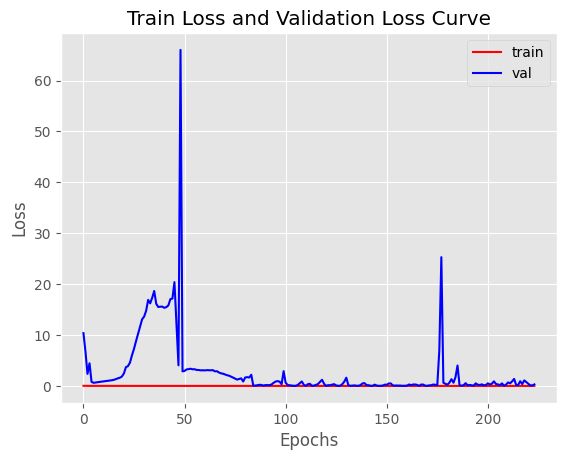

In [28]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [29]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


In [30]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.007231684411910562
RMSE = 0.08503931097974961
MAPE = 0.043395404908493314
R-Squared Score = 0.9129850132122829


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

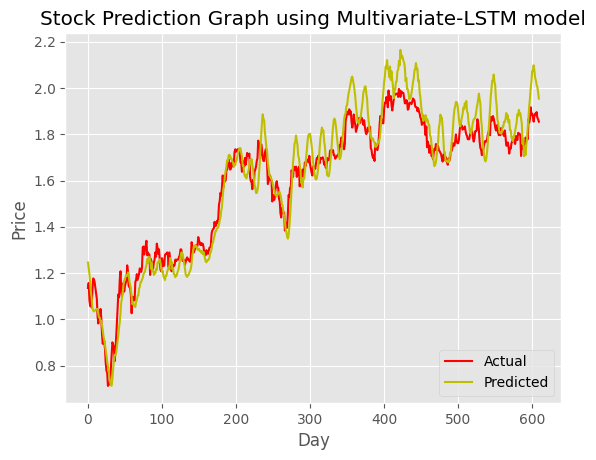

In [31]:
plot_data_4(true, predicted)

In [ ]:
# Save a model
model.save('10VAR-hpg-lstm.keras')

In [ ]:
del model